# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапов обработки металла

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.

1. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами (df_arc). Они установлены в крышке ковша.

2. Из сплава выводится сера (десульфурация)

3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали (df_temp) и производят её химический анализ.

4. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом (df_gas). Затем его перемешивают и снова проводят измерения.
Добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов (df_bulk)(df_bulk_time) или проволоку (df_wire)(df_wire_time) через специальный трайб-аппарат (англ. tribe, «масса»).

5. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

6. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime as dt

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

### Загрузка данных

In [3]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

#### df_arc

In [4]:
#данные об электродах
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,"14,876.00","14,876.00","14,876.00"
mean,"1,615.22",0.67,0.45
std,934.57,0.41,5.88
min,1.00,0.03,-715.50
25%,806.00,0.40,0.29
50%,"1,617.00",0.56,0.42
75%,"2,429.00",0.86,0.64
max,"3,241.00",3.73,2.68


In [7]:
df_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

Переименуем названия колонок в удобные для работы

In [8]:
df_arc = df_arc.rename(columns={'Начало нагрева дугой':'arc_start',
                                'Конец нагрева дугой':'arc_stop',
                                'Активная мощность':'active_power',
                                'Реактивная мощность':'reactive_power'})

Проверим на пропуски и явные дубликаты

In [9]:
df_arc.isna().sum()

key               0
arc_start         0
arc_stop          0
active_power      0
reactive_power    0
dtype: int64

In [10]:
df_arc.duplicated().sum()

0

Пропусков и дубликатов нет

(array([ 33.,  88., 151., 199., 337., 476., 624., 590., 597., 738., 895.,
        984., 844., 740., 612., 541., 488., 466., 410., 419., 429., 390.,
        302., 302., 280., 259., 234., 199., 212., 201., 174., 172., 148.,
        136., 122., 125., 101.,  88.,  80.,  57.,  60.,  56.,  47.,  39.,
         42.,  30.,  41.,  19.,  21.,  32.,  22.,  22.,  20.,  14.,  13.,
         15.,  19.,  10.,  10.,  10.,   5.,   6.,   7.,   7.,   5.,   8.,
          4.,   7.,   6.,   3.,   7.,   4.,   1.,   4.,   2.,   2.,   1.,
          1.,   2.,   2.,   1.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.03000194, 0.06701788, 0.10403382, 0.14104976, 0.17806571,
        0.21508165, 0.25209759, 0.28911353, 0.32612947, 0.36314541,
        0.40016136, 0.4371773 , 0.47419324, 0.51120918, 0.54822512,
        0.58524106, 0.62225701, 0.65927295, 0.69628889, 0.73330483,
        0.77032077, 0.80733671, 0.84435266, 0.

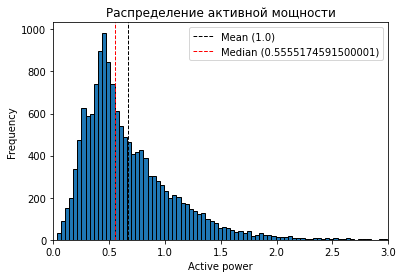

In [11]:
axes = plt.axes()
axes.set_xlim([0, 3])
plt.title('Распределение активной мощности')
plt.xlabel("Active power")
plt.ylabel("Frequency")
plt.axvline(df_arc['active_power'].mean(),
            color='k',
            linestyle='dashed',
            linewidth=1,
            label=f'Mean ({df_arc["active_power"].mean().round()})')
plt.axvline(df_arc['active_power'].median(),
            color='r',
            linestyle='dashed',
            linewidth=1,
            label=f'Median ({df_arc["active_power"].median()})')
plt.legend()
plt.hist(df_arc['active_power'],
         bins=100,
         edgecolor='k')

Распределение активной мощности скошено вправо

Text(0, 0.5, 'power')

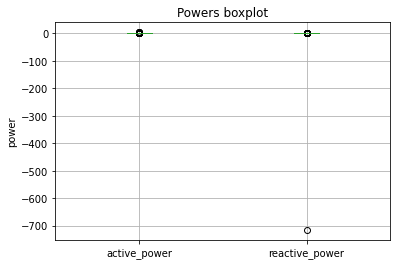

In [12]:
df_arc.boxplot(column=['active_power', 'reactive_power'], return_type='axes')
plt.title('Powers boxplot')
plt.ylabel('power')

Есть выбросы с экстремально большими и малыми значениями, в следующей части будем их удалять или попробуем заполнить медианой по партии.

(array([1., 0., 0., ..., 1., 0., 1.]),
 array([-715.50492418, -715.43310605, -715.36128792, ...,    2.53275129,
           2.60456942,    2.67638755]),
 <BarContainer object of 10000 artists>)

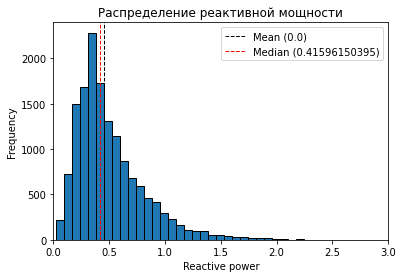

In [13]:
axes = plt.axes()
axes.set_xlim([0, 3])
plt.title('Распределение реактивной мощности')
plt.xlabel("Reactive power")
plt.ylabel("Frequency")
plt.axvline(df_arc['reactive_power'].mean(),
            color='k',
            linestyle='dashed',
            linewidth=1,
            label=f'Mean ({df_arc["reactive_power"].mean().round()})')
plt.axvline(df_arc['reactive_power'].median(),
            color='r',
            linestyle='dashed',
            linewidth=1,
            label=f'Median ({df_arc["reactive_power"].median()})')
plt.legend()
plt.hist(df_arc['reactive_power'],
         bins=10000,
         edgecolor='k')

Распределение реактивной мощности скошено вправо

В следующей части попробуем получить новый сборный признак - энергию(мощность на время) тк мощности мультиколинеарны

#### df_bulk

In [14]:
#данные о подаче сыпучих материалов (объём)
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


In [15]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,"3,129.00",252.00,22.00,"1,298.00","1,014.00",77.00,576.00,25.00,1.00,19.00,176.00,177.00,"2,450.00",18.00,"2,806.00","2,248.00"
mean,"1,624.38",39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.00,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,"1,622.00",31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,"2,431.00",46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,"3,241.00",185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.00,147.00,159.00,313.00,"1,849.00",305.00,636.00,405.00


In [17]:
df_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

Переименуем названия столбцов

In [18]:
for i in range(1, len(df_bulk.columns)):
    df_bulk = df_bulk.rename(columns={df_bulk.columns[i]:f'bulk_{i}'})

In [19]:
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Проверим на пропуски и явные дубликаты

In [20]:
df_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

In [21]:
df_bulk.duplicated().sum()

0

В следующей части разные присадки просуммируем и сделать общий bulk на партию

#### df_bulk_time

In [22]:
#данные о подаче сыпучих материалов (время)
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [23]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [24]:
df_bulk_time.describe()

,key
count,"3,129.00"
mean,"1,624.38"
std,933.34
min,1.00
25%,816.00
50%,"1,622.00"
75%,"2,431.00"
max,"3,241.00"


In [25]:
df_bulk_time.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

Переименуем названия столбцов

In [26]:
for i in range(1, len(df_bulk_time.columns)):
    df_bulk_time = df_bulk_time.rename(columns={df_bulk_time.columns[i]:f'bulk_{i}'})

In [27]:
df_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Данные о подаче сыпучих материалов (время) будем использовать, чтобы разложить процесс по времени

#### df_gas

In [28]:
#данные о продувке сплава газом
df_gas.head()

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


In [29]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [30]:
df_gas.describe()

,key,Газ 1
count,"3,239.00","3,239.00"
mean,"1,621.86",11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,"1,622.00",9.84
75%,"2,431.50",13.77
max,"3,241.00",78.00


In [31]:
df_gas.columns

Index(['key', 'Газ 1'], dtype='object')

Переименуем названия столбцов

In [32]:
df_gas = df_gas.rename(columns={'Газ 1':'gas'})

Проверим на пропуски и явные дубликаты

In [33]:
df_gas.isna().sum()

key    0
gas    0
dtype: int64

In [34]:
df_gas.duplicated().sum()

0

(array([ 17.,  34.,  50.,  58.,  66.,  93., 115., 161., 213., 242., 223.,
        217., 231., 203., 162., 144., 132., 112., 101.,  93.,  80.,  63.,
         65.,  52.,  41.,  24.,  42.,  21.,  21.,  29.,  18.,  13.,  14.,
         11.,   8.,   4.,  10.,   6.,  10.,   6.,   5.,   5.,   3.,   4.,
          1.,   2.,   0.,   1.,   0.,   2.,   3.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([8.39852910e-03, 7.88264940e-01, 1.56813135e+00, 2.34799776e+00,
        3.12786417e+00, 3.90773059e+00, 4.68759700e+00, 5.46746341e+00,
        6.24732982e+00, 7.02719623e+00, 7.80706264e+00, 8.58692905e+00,
        9.36679547e+00, 1.01466619e+01, 1.09265283e+01, 1.17063947e+01,
        1.24862611e+01, 1.3266

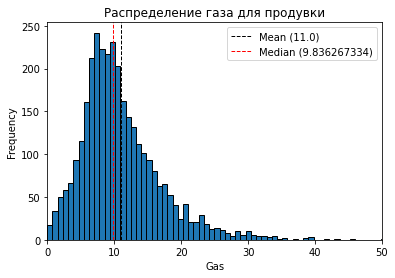

In [35]:
axes = plt.axes()
axes.set_xlim([0, 50])
plt.title('Распределение газа для продувки')
plt.xlabel("Gas")
plt.ylabel("Frequency")
plt.axvline(df_gas['gas'].mean(),
            color='k',
            linestyle='dashed',
            linewidth=1,
            label=f'Mean ({df_gas["gas"].mean().round()})')
plt.axvline(df_gas['gas'].median(),
            color='r',
            linestyle='dashed',
            linewidth=1,
            label=f'Median ({df_gas["gas"].median()})')
plt.legend()
plt.hist(df_gas['gas'],
         bins=100,
         edgecolor='k')

Text(0, 0.5, 'gas')

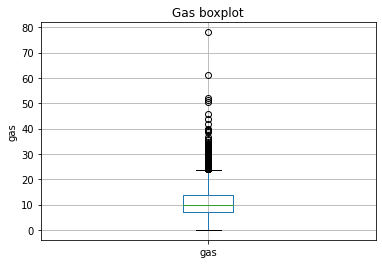

In [36]:
df_gas.boxplot(column=['gas'], return_type='axes')
plt.title('Gas boxplot')
plt.ylabel('gas')

Распределение газа для продувки скошено вправо, есть выбросы

#### df_temp

In [37]:
#результаты измерения температуры (target)
#df_temp = pd.read_csv('data_temp.csv')
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,"1,571.00"
1,1,2019-05-03 11:25:53,"1,604.00"
2,1,2019-05-03 11:29:11,"1,618.00"
3,1,2019-05-03 11:30:01,"1,601.00"
4,1,2019-05-03 11:30:39,"1,613.00"


In [38]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [39]:
df_temp.describe()

,key,Температура
count,"15,907.00","13,006.00"
mean,"1,607.88","1,591.84"
std,942.21,21.38
min,1.00,"1,191.00"
25%,790.00,"1,581.00"
50%,"1,618.00","1,591.00"
75%,"2,427.00","1,601.00"
max,"3,241.00","1,705.00"


In [40]:
df_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

Переименуем названия столбцов

In [41]:
df_temp = df_temp.rename(columns={'Время замера':'time',
                                  'Температура':'temperature'})

Проверим на пропуски и явные дубликаты

In [42]:
df_temp.isna().sum()

key               0
time              0
temperature    2901
dtype: int64

In [43]:
df_temp.duplicated().sum()

0

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 1.400e+01,
        2.500e+01, 4.300e+01, 6.000e+01, 9.400e+01, 1.260e+02, 2.480e+02,
        3.330e+02, 5.340e+02, 8.740e+02, 1.081e+03, 1.386e+03, 1.858e+03,
        2.185e+03, 1.199e+03, 7.470e+0

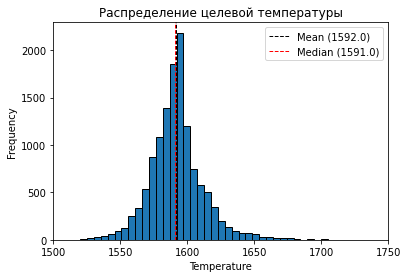

In [44]:
axes = plt.axes()
axes.set_xlim([1500, 1750])
plt.title('Распределение целевой температуры')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.axvline(df_temp['temperature'].mean(),
            color='k',
            linestyle='dashed',
            linewidth=1,
            label=f'Mean ({df_temp["temperature"].mean().round()})')
plt.axvline(df_temp['temperature'].median(),
            color='r',
            linestyle='dashed',
            linewidth=1,
            label=f'Median ({df_temp["temperature"].median()})')
plt.legend()
plt.hist(df_temp['temperature'],
         bins=100,
         edgecolor='k')

Text(0, 0.5, 'temperature')

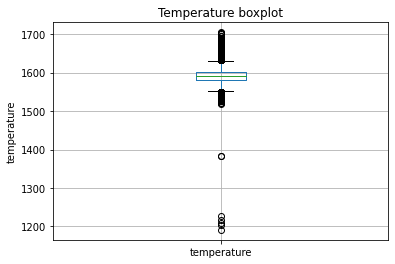

In [45]:
df_temp.boxplot(column=['temperature'], return_type='axes')
plt.title('Temperature boxplot')
plt.ylabel('temperature')

Обнаружили пропуски и выбросы в целевом признаке, в следующей части будем убирать из датафрейма всю партию.
Если начальная температура и последняя равны, то будем удалять строку.
Проверим наличие более двух замеров.
Партии где после измерения последней температуры есть еще операции - присыпки - удалим.

#### df_wire

In [46]:
#данные о проволочных материалах (объём)
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [48]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,"3,081.00","3,055.00","1,079.00",63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,"1,623.43",100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,"1,619.00",100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,"2,434.00",126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,"3,241.00",330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


In [49]:
df_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Переименуем названия столбцов

In [50]:
for i in range(1, len(df_wire.columns)):
    df_wire = df_wire.rename(columns={df_wire.columns[i]:f'wire_{i}'})

Проверим на пропуски и явные дубликаты

In [51]:
df_wire.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

In [52]:
df_wire.duplicated().sum()

0

В следующей части разные присадки просуммируем и сделаем общий wire

#### df_wire_time

In [53]:
#данные о проволочных материалах (время)
#df_wire_time = pd.read_csv('data_wire_time.csv')
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [55]:
df_wire_time.describe()

,key
count,"3,081.00"
mean,"1,623.43"
std,933.00
min,1.00
25%,823.00
50%,"1,619.00"
75%,"2,434.00"
max,"3,241.00"


In [56]:
df_wire_time.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Переименуем названия столбцов

In [57]:
for i in range(1, len(df_wire_time.columns)):
    df_wire_time = df_wire_time.rename(columns={df_wire_time.columns[i]:f'wire_{i}'})

In [58]:
df_wire_time.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

In [59]:
df_wire_time.duplicated().sum()

0

Данные о проволочных материалах (время) будем использовать, чтобы разложить процесс по времени

### Генерация признаков

In [60]:
df_arc.head()

,key,arc_start,arc_stop,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41


Очищаем от выбросов в измеренных значения мощностей

In [61]:
df_arc = df_arc[df_arc['active_power'] > 0]
df_arc = df_arc[df_arc['reactive_power'] > -500]

Создадим новые признаки - энергию затраченную на нагрев (время * полную мощность) и время нагрева

In [62]:
df_arc['arc_start'] = pd.to_datetime(df_arc['arc_start'], format = '%Y-%m-%d %H:%M:%S')
df_arc['arc_stop'] = pd.to_datetime(df_arc['arc_stop'], format = '%Y-%m-%d %H:%M:%S')

df_arc['energy'] = (df_arc['arc_stop'] - df_arc['arc_start']).dt.total_seconds()*((
    df_arc['active_power'])**2+(df_arc['reactive_power'])**2)**0.5
df_arc['delta'] = (df_arc['arc_stop'] - df_arc['arc_start']).dt.total_seconds()/60
df_arc

,key,arc_start,arc_stop,active_power,reactive_power,energy,delta
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69,272.15,3.80
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52,177.42,3.08
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50,154.12,2.87
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06,719.22,6.08
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41,119.47,2.47
...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.53,0.35,100.58,2.62
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.68,0.52,154.00,3.00
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.73,0.48,160.92,3.07
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.22,0.15,15.08,0.95


Сгруппируем данные по партии, покажем время начала первого нагрева и время окончания последнего, затраченную энергию на партию просуммируем, посчитаем сколько раз происходил нагрев

In [63]:
df_arc = df_arc.groupby('key').agg({'arc_start':'min',
                          'arc_stop':'max',
                          'energy':'sum',
                          'active_power':'count',
                          'delta':'sum'
                          }).reset_index()

In [64]:
df_arc = df_arc.rename(columns={'active_power':'count_arc'})
df_arc

,key,arc_start,arc_stop,energy,count_arc,delta
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,"1,442.38",5,18.30
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,881.23,4,13.52
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,525.07,5,10.92
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,796.91,4,12.35
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,"1,199.14",4,14.48
...,...,...,...,...,...,...
3209,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,958.34,5,15.15
3210,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,555.87,3,9.10
3211,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,"1,013.07",8,20.27
3212,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,729.21,5,13.98


In [65]:
df_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


Заполним пропуски нулями (примесь не добавляли) и просуммируем добавленные в партию добавки

In [66]:
col = list(df_bulk.columns[1:16])
df_bulk = df_bulk.fillna(0)

df_bulk['bulk'] = df_bulk[col].sum(axis=1)
df_bulk.drop(col, axis=1, inplace=True)
df_bulk

,key,bulk
0,1,553.00
1,2,582.00
2,3,544.00
3,4,595.00
4,5,584.00
...,...,...
3124,3237,758.00
3125,3238,594.00
3126,3239,630.00
3127,3240,272.00


In [67]:
df_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Приведем формат времени к datetime

In [68]:
for i in range(1, len(df_bulk_time.columns)):
    df_bulk_time[df_bulk_time.columns[i]] = pd.to_datetime(df_bulk_time[df_bulk_time.columns[i]], format = '%Y-%m-%d %H:%M:%S')

Найдем максимальное и минимальное время добавок примесей, чтобы потом отсеить партии в которых были добавки после измерения температуры

In [69]:
df_bulk_time['max_bulk_time'] = df_bulk_time.iloc[:,1:16].max(axis=1)
df_bulk_time['min_bulk_time'] = df_bulk_time.iloc[:,1:16].min(axis=1)

df_bulk_time = df_bulk_time[['key', 'max_bulk_time', 'min_bulk_time']]
df_bulk_time

,key,max_bulk_time,min_bulk_time
0,1,2019-05-03 11:21:30,2019-05-03 11:03:52
1,2,2019-05-03 11:46:38,2019-05-03 11:40:20
2,3,2019-05-03 12:31:06,2019-05-03 12:09:40
3,4,2019-05-03 12:48:43,2019-05-03 12:41:24
4,5,2019-05-03 13:18:50,2019-05-03 13:12:56
...,...,...,...
3124,3237,2019-08-31 22:51:28,2019-08-31 22:46:52
3125,3238,2019-08-31 23:39:11,2019-08-31 23:33:09
3126,3239,2019-09-01 01:51:58,2019-09-01 01:33:25
3127,3240,2019-09-01 03:12:40,2019-09-01 02:41:27


In [70]:
df_gas.head()

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


In [71]:
df_min_temp_temperature = df_temp
df_max_temp_temperature = df_temp

In [72]:
df_temp.head(10)

,key,time,temperature
0,1,2019-05-03 11:16:18,"1,571.00"
1,1,2019-05-03 11:25:53,"1,604.00"
2,1,2019-05-03 11:29:11,"1,618.00"
3,1,2019-05-03 11:30:01,"1,601.00"
4,1,2019-05-03 11:30:39,"1,613.00"
5,2,2019-05-03 11:37:27,"1,581.00"
6,2,2019-05-03 11:38:00,"1,577.00"
7,2,2019-05-03 11:49:38,"1,589.00"
8,2,2019-05-03 11:55:50,"1,604.00"
9,2,2019-05-03 11:58:24,"1,608.00"


Приведем время измерения температуры к datetime

In [73]:
df_temp['time'] = pd.to_datetime(df_temp['time'], format = '%Y-%m-%d %H:%M:%S')

Найдем максимальное и минимальное время измерения температуры, чтобы потом отсеить партии в которых были добавки после измерения температуры. Определим количество измерений в партии, чтобы оставить только те партии в которых больше двух измерений

In [74]:
df_temp = df_temp.groupby('key')['time'].agg(['min', 'max', 'count']).reset_index()

In [75]:
df_temp = df_temp.rename(columns={'min':'min_time_temp',
                                 'max':'max_time_temp',
                                 'count':'count_temp',
                                 'delta':'delta_time'})

In [76]:
df_temp

,key,min_time_temp,max_time_temp,count_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2
...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8


In [77]:
df_min_temp_temperature = df_min_temp_temperature.rename(columns={'time':'min_time_temp'})

Найдем температуру первого измерения и последнего (целевой признак)

In [78]:
df_temp = pd.merge(df_temp, df_min_temp_temperature[['min_time_temp', 'temperature']], how ='left', on ='min_time_temp')

In [79]:
df_temp = df_temp.rename(columns={'temperature':'min_temp'})

In [80]:
df_temp

,key,min_time_temp,max_time_temp,count_temp,min_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.00"
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.00"
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.00"
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.00"
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,"1,576.00"
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5,"1,569.00"
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3,"1,584.00"
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8,"1,598.00"
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8,"1,617.00"


In [81]:
df_max_temp_temperature = df_max_temp_temperature.rename(columns={'time':'max_time_temp'})

In [82]:
df_temp = pd.merge(df_temp, df_max_temp_temperature[['max_time_temp', 'temperature']],
                   how ='left', on ='max_time_temp')

In [83]:
df_temp = df_temp.rename(columns={'temperature':'max_temp'})

In [84]:
df_temp

,key,min_time_temp,max_time_temp,count_temp,min_temp,max_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.00","1,613.00"
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.00","1,602.00"
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.00","1,599.00"
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.00","1,625.00"
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,"1,576.00","1,602.00"
...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5,"1,569.00",NaN
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3,"1,584.00",NaN
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8,"1,598.00",NaN
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8,"1,617.00",NaN


Оставим только те партии, где количество измерений температуры больше двух

In [85]:
df_temp = df_temp[df_temp['count_temp'] > 2]

In [106]:
df_temp

,key,min_time_temp,max_time_temp,count_temp,min_temp,max_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,"1,571.00","1,613.00"
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,"1,581.00","1,602.00"
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,"1,596.00","1,599.00"
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,"1,601.00","1,625.00"
5,6,2019-05-03 13:49:24,2019-05-03 14:12:29,5,"1,543.00","1,596.00"
...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,5,"1,569.00",NaN
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,3,"1,584.00",NaN
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,8,"1,598.00",NaN
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,8,"1,617.00",NaN


In [86]:
df_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заполним пропуски нулями (примесь не добавляли) и просуммируем добавленные в партию добавки

In [87]:
col = list(df_wire.columns[1:10])
df_wire = df_wire.fillna(0)
df_wire['wire'] = df_wire[col].sum(axis=1)
df_wire.drop(col, axis=1, inplace=True)
df_wire

,key,wire
0,1,60.06
1,2,96.05
2,3,91.16
3,4,89.06
4,5,98.35
...,...,...
3076,3237,38.09
3077,3238,56.13
3078,3239,143.36
3079,3240,34.07


In [88]:
df_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Приведем формат времени к datetime

In [89]:
for i in range(1, len(df_wire_time.columns)):
    df_wire_time[df_wire_time.columns[i]] = pd.to_datetime(df_wire_time[df_wire_time.columns[i]], format = '%Y-%m-%d %H:%M:%S')

Найдем максимальное и минимальное время добавок примесей, чтобы потом отсеить партии в которых были добавки после измерения температуры

In [90]:
df_wire_time['max_wire_time'] = df_wire_time.iloc[:,1:10].max(axis=1)
df_wire_time['min_wire_time'] = df_wire_time.iloc[:,1:10].min(axis=1)
df_wire_time = df_wire_time[['key', 'max_wire_time', 'min_wire_time']]
df_wire_time

,key,max_wire_time,min_wire_time
0,1,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,2019-05-03 13:32:06,2019-05-03 13:18:15
...,...,...,...
3076,3237,2019-08-31 22:50:20,2019-08-31 22:50:20
3077,3238,2019-08-31 23:38:24,2019-08-31 23:38:24
3078,3239,2019-09-01 01:50:43,2019-09-01 01:50:43
3079,3240,2019-09-01 03:12:02,2019-09-01 03:12:02


### Объединение данных в сводную таблицу

Левая таблица - таблица с таргетом, к ней, по ключу, присоединяем остальные таблицы

In [91]:
df = pd.merge(df_temp, df_arc, how='left', on='key')

Оставляем только те партии, где измерение температуры было после окончания нагрева

In [92]:
df = df[df['max_time_temp'] > df['arc_stop']]

Оставляем только те партии, где первое измерение температуры было до начала нагрева, нам важно это условие для правильного предсказания температуры и экономии электроэнергии

Фиксируем, что температура поменялась, те был нагрев

In [93]:
df = df[df['min_temp'] != df['max_temp']]

In [94]:
df.drop(columns=['count_temp', 'arc_start', 'arc_stop'], inplace = True)

Добавляем данные с добавками

In [95]:
df = pd.merge(df, df_bulk_time, how='left', on='key')

Проверяем, что не было добавок после измерения температуры

In [96]:
df = df[df['max_time_temp'] > df['max_bulk_time']]

Добавляем данные о добавках

In [97]:
df = pd.merge(df, df_bulk, how='left', on='key')

In [98]:
df = pd.merge(df, df_wire_time, how='left', on='key')
df

,key,min_time_temp,max_time_temp,min_temp,max_temp,energy,count_arc,delta,max_bulk_time,min_bulk_time,bulk,max_wire_time,min_wire_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,"1,571.00","1,613.00","1,442.38",5,18.30,2019-05-03 11:21:30,2019-05-03 11:03:52,553.00,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,"1,581.00","1,602.00",881.23,4,13.52,2019-05-03 11:46:38,2019-05-03 11:40:20,582.00,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,"1,596.00","1,599.00",525.07,5,10.92,2019-05-03 12:31:06,2019-05-03 12:09:40,544.00,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,"1,601.00","1,625.00",796.91,4,12.35,2019-05-03 12:48:43,2019-05-03 12:41:24,595.00,2019-05-03 12:48:05,2019-05-03 12:48:05
4,6,2019-05-03 13:49:24,2019-05-03 14:12:29,"1,543.00","1,596.00","1,410.75",4,15.87,2019-05-03 13:59:24,2019-05-03 13:53:27,676.00,2019-05-03 13:59:54,2019-05-03 13:59:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,"1,569.00",NaN,958.34,5,15.15,2019-08-31 22:51:28,2019-08-31 22:46:52,758.00,2019-08-31 22:50:20,2019-08-31 22:50:20
2857,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,"1,584.00",NaN,555.87,3,9.10,2019-08-31 23:39:11,2019-08-31 23:33:09,594.00,2019-08-31 23:38:24,2019-08-31 23:38:24
2858,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,"1,598.00",NaN,"1,013.07",8,20.27,2019-09-01 01:51:58,2019-09-01 01:33:25,630.00,2019-09-01 01:50:43,2019-09-01 01:50:43
2859,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,"1,617.00",NaN,729.21,5,13.98,2019-09-01 03:12:40,2019-09-01 02:41:27,272.00,2019-09-01 03:12:02,2019-09-01 03:12:02


Проверяем, что небыло добавок после последнего измерения

In [99]:
df[df['max_time_temp'] < df['max_wire_time']]

,key,min_time_temp,max_time_temp,min_temp,max_temp,energy,count_arc,delta,max_bulk_time,min_bulk_time,bulk,max_wire_time,min_wire_time


In [100]:
df = pd.merge(df, df_wire, how='left', on='key')
df = pd.merge(df, df_gas, how='left', on='key')

In [101]:
df.drop(columns=['max_bulk_time', 'min_bulk_time', 'max_wire_time', 'min_wire_time', 'min_time_temp', 'max_time_temp'], inplace = True)

In [102]:
df['wire'] = df['wire'].fillna(0)
df['gas'] = df['gas'].fillna(0)
df = df.dropna()

In [103]:
df.isna().sum()

key          0
min_temp     0
max_temp     0
energy       0
count_arc    0
delta        0
bulk         0
wire         0
gas          0
dtype: int64

In [104]:
df.corr()

,key,min_temp,max_temp,energy,count_arc,delta,bulk,wire,gas
key,1.00,-0.01,-0.07,-0.01,-0.03,-0.03,-0.03,0.01,-0.05
min_temp,-0.01,1.00,0.33,-0.29,-0.16,-0.29,-0.10,0.03,0.02
max_temp,-0.07,0.33,1.00,0.29,0.08,0.23,0.10,-0.14,-0.01
energy,-0.01,-0.29,0.29,1.00,0.51,0.89,0.51,-0.02,0.29
count_arc,-0.03,-0.16,0.08,0.51,1.00,0.79,0.43,0.19,0.40
delta,-0.03,-0.29,0.23,0.89,0.79,1.00,0.54,0.08,0.38
bulk,-0.03,-0.10,0.10,0.51,0.43,0.54,1.00,0.03,0.30
wire,0.01,0.03,-0.14,-0.02,0.19,0.08,0.03,1.00,0.22
gas,-0.05,0.02,-0.01,0.29,0.40,0.38,0.30,0.22,1.00


In [107]:
df

,key,min_temp,max_temp,energy,count_arc,delta,bulk,wire,gas
0,1,"1,571.00","1,613.00","1,442.38",5,18.30,553.00,60.06,29.75
1,2,"1,581.00","1,602.00",881.23,4,13.52,582.00,96.05,12.56
2,3,"1,596.00","1,599.00",525.07,5,10.92,544.00,91.16,28.55
3,4,"1,601.00","1,625.00",796.91,4,12.35,595.00,89.06,18.84
4,6,"1,543.00","1,596.00","1,410.75",4,15.87,676.00,108.22,11.27
...,...,...,...,...,...,...,...,...,...
2186,2494,"1,585.00","1,591.00",634.54,3,9.17,591.00,75.04,3.98
2187,2495,"1,570.00","1,591.00",778.82,4,12.05,719.00,89.15,7.13
2188,2496,"1,554.00","1,591.00",875.26,6,15.67,796.00,114.18,9.41
2189,2498,"1,591.00","1,594.00",767.82,5,12.50,733.00,118.11,14.95


## Подготовка моделей:

### Определение тестовой и тренировочной выборок

Выделим признаки и целевой признак

In [108]:
target = df['max_temp']
features = df.drop(['max_temp'] , axis=1)

Выделим тестовую подвыборку

In [109]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=17)

In [110]:
print(f'Размер Train: features {features_train.shape} target {target_train.shape}')
print(f'Размер Test: features {features_test.shape} target {target_test.shape}')

Размер Train: features (1643, 8) target (1643,)
Размер Test: features (548, 8) target (548,)


### Линейная регрессия

In [111]:
lr = LinearRegression().fit(features_train, target_train)

In [112]:
scores = cross_val_score(lr,
                        features_train,
                        target_train,
                        scoring="neg_mean_absolute_error",
                        cv = 5)

In [113]:
print('Train scores:')
print('mae = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores,
                                                            scores.mean(),
                                                            scores.std()))
print()
print('Test scores:')
scores= cross_val_score(lr,
                        features_test,
                        target_test,
                        scoring="neg_mean_absolute_error",
                        cv = 5)
print('mae = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores,
                                                            scores.mean(),
                                                            scores.std()))

Train scores:
mae = [-7.36791947 -8.93917509 -7.99357815 -8.37177913 -8.46414377] 
mean score = -8.22732 +/- 0.52477

Test scores:
mae = [-6.91190215 -9.90328082 -7.65871653 -8.45864344 -8.27147184] 
mean score = -8.24080 +/- 0.99167


### Random forest regression

In [111]:
forest = RandomForestRegressor(
    random_state=17,
    max_depth=10
)

In [112]:
forest_params = { 
                'n_estimators': [200,300,400,500],
                'max_features': ['sqrt','log2'],
                'max_depth' : [3,4,5,6,7],
                'random_state' : [17]
                }

In [113]:
forest_grid = GridSearchCV(forest,
                           forest_params,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error'
                          )

In [114]:
forest_grid.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [17]},
             scoring='neg_mean_absolute_error')

In [115]:
print(forest_grid.best_params_, forest_grid.best_score_)

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500, 'random_state': 17} -6.976925167692833


In [116]:
print(mean_absolute_error(target_test, forest_grid.predict(features_test)))

6.946260233183737


### CatBoost regression

Обучим модель градиентного бустинга CatBoost регрессию

In [114]:
catb = CatBoostRegressor(loss_function="MAE", verbose=500, n_estimators=1900, depth=4, learning_rate=0.05)

In [115]:
catb.fit(features_train, target_train)

0:	learn: 9.2986600	total: 47.4ms	remaining: 1m 30s
500:	learn: 5.1564438	total: 522ms	remaining: 1.46s
1000:	learn: 4.6621537	total: 983ms	remaining: 883ms
1500:	learn: 4.4041435	total: 1.46s	remaining: 387ms
1899:	learn: 4.2267621	total: 1.82s	remaining: 0us


In [116]:
catb_pred = catb.predict(features_test)

In [117]:
print(mean_absolute_error(catb_pred, target_test))

6.5067627997202235


Лучшая оценка на тесте

### LightGBM regression

In [118]:
lgbm = LGBMRegressor(max_depth=4, learning_rate=0.05)

In [122]:
lgbm.fit(features_train,
            target_train,
            verbose=50)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(learning_rate=0.05, max_depth=4)

In [123]:
lgbm_pred = lgbm.predict(features_test)

In [124]:
print(mean_absolute_error(lgbm_pred, target_test))

6.920233793855818


## Тестирование модели

### Анализ важности факторов

<AxesSubplot:>

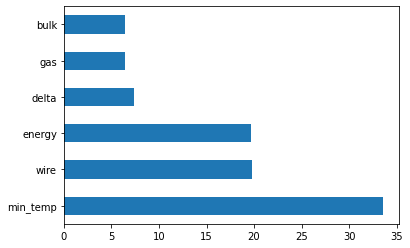

In [125]:
(pd.Series(catb.feature_importances_, index=features_test.columns)
   .nlargest(6)
   .plot(kind='barh'))

Лучшая оценка на тестовой выборке у модели CatBoost regressor - 6.5 <br>
Наиболее важные признаки - начальная температура, затраченная энергия и данные о проводлочных материалах.

## Выводы и отчет по проделанной работе

Целью работы было построить модель, которая предскажет температуру стали в технологическом процессе на металлургическом комбинате ООО «Так закаляем сталь» с целью уменьшить потребление электроэнергии на этапе обработки стали. <br>
В ходе работы были выполнены все намеченые пункты:
1. Проведен исследовательский анализ данных:
    - Проанализировали порядок событий в производственном процессе
    - Посмотрели на распределение исходных данных
    - Очистили данные от выбросов и шумов
2. Сгенерировали признаки, на которых будет обучаться модель:
    - Сгенерировали новые признаки
    - Проверили признаки на мультиколлинеарность, исключили лишние
3. Построили модель, которая предскажет температуру стали:
    - Сформировали обучающую и тестовую выборки
    - Выбрали несколько моделей и проверили их эффективность на кросвалидации с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверили на тестовой выборке

В ходе подготовки данных были расчитаны и добавлены новые признаки:
- суммарная энергия затраченая на нагрев партии
- колличество подогревов стали
- суммарное время нагрева стали

Самым важным этапом в работе была подготовка данных к моделированию. Каждый шаг оказывал сильное влияние на итоговую оценку. Например очистка от выбросов значений реактивной мощности дает прирост в МАЕ около 2 градусов. Одной из самых сложных частей проекта было разложение данных технологического процесса по времени выполнения основных этапов, удаление партий которые не подходят кртитериям и на основе полученных данных составление итоговой таблицы признаков. Последовательное аккуратное выполнение этапов подготовки, очистки и слияния таблиц в исходную помогло предотвратить возможные ошибки и неправильный итоговый результат. Также важной частью является выбор и настройка модели, точный выбор правильных параметров позволил улучшить результат на 0,2 - 0,3 градусов.

В финальной части были обучены модели:
- Линейная регрессия
- Random Forest regression
- CatBoost regression
- LightGBM regression

Итоговой моделью была выбрана CatBoost регрессия, с оценками MAE на тестовой выборке - 6.5, что удовлетворяет условиям задачи. <br>
Наиболее важные признаки - начальная температура, затраченная энергия и данные о проводлочных материалах.